In [70]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import time
from tensorflow.keras import layers, models, optimizers


# 1. Introduction

In this lab, we implement and compare two CNN architectures for image classification on CIFAR-10 and MNIST datasets.

Our goals are:

- Design a custom CNN.
- Implement AlexNet-inspired architecture.
- Compare their performances.
- Improve weak class predictions with data augmentation.


In [71]:

(cifar_train_images, cifar_train_labels), (cifar_test_images, cifar_test_labels) = tf.keras.datasets.cifar10.load_data()

cifar_train_images = cifar_train_images.astype('float32') / 255.0
cifar_test_images = cifar_test_images.astype('float32') / 255.0

print(f"CIFAR-10 training samples: {cifar_train_images.shape[0]}")
print(f"CIFAR-10 test samples: {cifar_test_images.shape[0]}")

def sample_per_class(images, labels, percent=1):
    sampled_images = []
    sampled_labels = []
    classes = np.unique(labels)
    for c in classes:
        idx = np.where(labels == c)[0]
        sample_size = int(len(idx) * percent)
        sampled_idx = np.random.choice(idx, sample_size, replace=False)
        sampled_images.append(images[sampled_idx])
        sampled_labels.append(labels[sampled_idx])
    return np.concatenate(sampled_images), np.concatenate(sampled_labels)

sampled_train_images, sampled_train_labels = sample_per_class(cifar_train_images, cifar_train_labels, 1)

print(f"Sampled training samples: {sampled_train_images.shape[0]}")

print(f"Sampled train images shape: {sampled_train_images.shape}")
print(f"Sampled train labels shape: {sampled_train_labels.shape}")


CIFAR-10 training samples: 50000
CIFAR-10 test samples: 10000
Sampled training samples: 50000
Sampled train images shape: (50000, 32, 32, 3)
Sampled train labels shape: (50000, 1)


# 3. Custom CNN Implementation

Let's design a simple but effective CNN with:

- Two convolutional layers with ReLU activation.
- MaxPooling layers after each conv layer.
- Dropout for regularization.
- Dense output layer with softmax.

We'll experiment with hyperparameters such as:
- Number of filters: 32, 64
- Kernel size: 3x3
- Dropout rate: 0.25
- Optimizer: Adam

We'll train for 15 epochs and observe training/validation performance.


In [72]:
def create_custom_cnn(input_shape=(32,32,3), num_classes=10, dropout_rate=0.25):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

custom_cnn = create_custom_cnn()
custom_cnn.compile(optimizer=optimizers.Adam(learning_rate=1e-4),  # Lower LR
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

custom_cnn.summary()

/Users/tudoriliescu/MH/Iliescu_Tudor_L6/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 316,106 (1.21 MB)

 Trainable params: 315,914 (1.21 MB)

 Non-trainable params: 192 (768.00 B)

In [73]:
sampled_train_labels = np.array(sampled_train_labels).flatten()

In [74]:

start = time.time()
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    sampled_train_images, sampled_train_labels, test_size=0.2, random_state=42, stratify=sampled_train_labels)

history_custom = custom_cnn.fit(X_train, y_train,
                               epochs=15,
                               batch_size=64,
                               validation_data=(X_val, y_val))


end = time.time()
print(f"Training time for Custom CNN: {end - start:.2f} seconds")


Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.2741 - loss: 2.7945 - val_accuracy: 0.4302 - val_loss: 1.6255
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.3989 - loss: 1.9355 - val_accuracy: 0.4940 - val_loss: 1.4863
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.4632 - loss: 1.6812 - val_accuracy: 0.5121 - val_loss: 1.4272
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5033 - loss: 1.5238 - val_accuracy: 0.5370 - val_loss: 1.3529
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5253 - loss: 1.4319 - val_accuracy: 0.5627 - val_loss: 1.2875
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5563 - loss: 1.3635 - val_accuracy: 0.5873 - val_loss: 1.2050
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5630 - loss: 1.3099 - val_accuracy: 0.5829 - val_loss: 1.2226
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5769 - loss: 1.2716 - val_acc

# 4. AlexNet Implementation

AlexNet is a deeper architecture known for revolutionizing CNNs in 2012.

We'll implement a simplified version adapted to CIFAR-10 input size (32x32x3).

Main components:
- 5 convolutional layers with ReLU
- MaxPooling layers
- Dropout layers for regularization
- Fully connected dense layers with dropout
- Softmax output layer

This implementation is inspired by the original paper but adjusted for smaller input size.


In [77]:
def create_alexnet(input_shape=(32,32,3), num_classes=10):
    model = models.Sequential()

    model.add(layers.Conv2D(96, (3,3), strides=1, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(384, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(384, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

alexnet_model = create_alexnet()
alexnet_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4, clipvalue=1.0),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

alexnet_model.summary()


/Users/tudoriliescu/MH/Iliescu_Tudor_L6/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 30, 30, 96)     │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 15, 15, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 15, 15, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 15, 15, 256)    │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 7, 7, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 7, 7, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 7, 7, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1024)           │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,744,330 (25.73 MB)

 Trainable params: 6,743,114 (25.72 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [78]:

start = time.time()

X_train, X_val, y_train, y_val = train_test_split(
    sampled_train_images, sampled_train_labels, test_size=0.2, random_state=42, stratify=sampled_train_labels)

history_alexnet = alexnet_model.fit(X_train, y_train,
                                    epochs=15,
                                    batch_size=64,
                                    validation_data=(X_val, y_val))

end = time.time()
print(f"Training time for AlexNet: {end - start:.2f} seconds")


Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - accuracy: 0.2633 - loss: 3.8716 - val_accuracy: 0.4723 - val_loss: 1.6657
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 60ms/step - accuracy: 0.3649 - loss: 3.9063 - val_accuracy: 0.5651 - val_loss: 1.7323
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - accuracy: 0.4428 - loss: 3.3987 - val_accuracy: 0.5514 - val_loss: 2.1481
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.4824 - loss: 3.0680 - val_accuracy: 0.5622 - val_loss: 1.9585
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.5251 - loss: 2.5408 - val_accuracy: 0.6166 - val_loss: 1.5730
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 60ms/step - accuracy: 0.5669 - loss: 2.2505 - val_accuracy: 0.6432 - val_loss: 1.5105
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 60ms/step - accuracy: 0.5952 - loss: 1.9367 - val_accuracy: 0.6739 - val_loss: 1.2181
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.6213 - loss: 1.7062 - 

# 5. Performance Comparison

Let's plot training and validation accuracy/loss curves for both models and evaluate test accuracy.

We will also display confusion matrices to analyze class-wise performance.


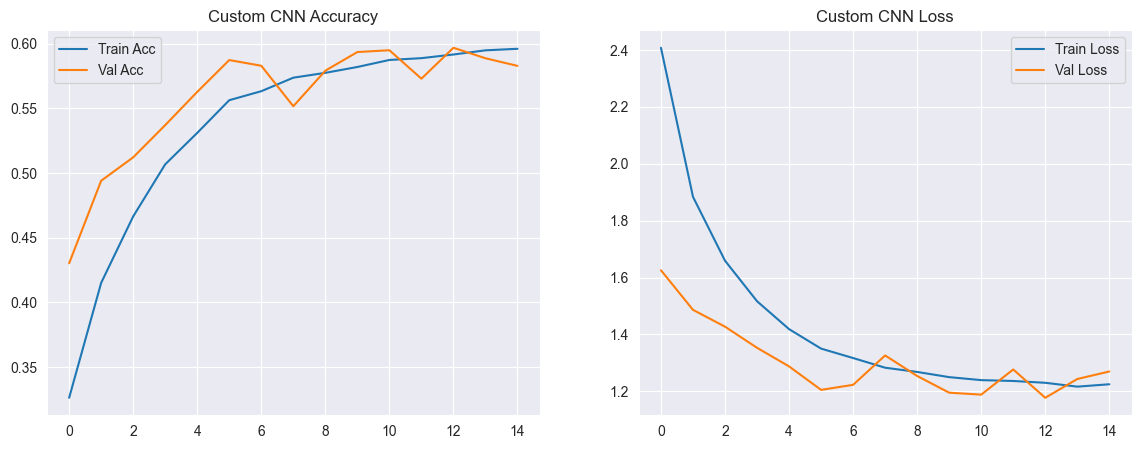

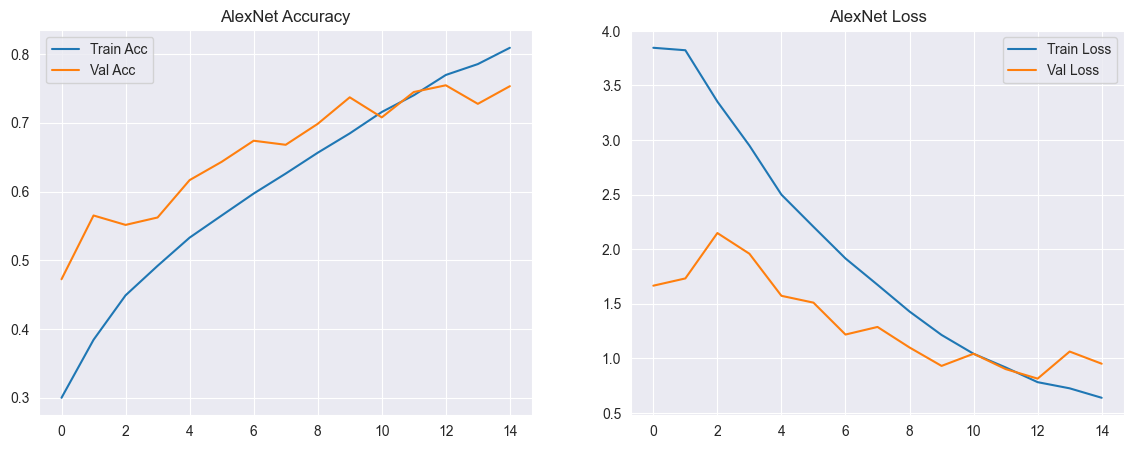

In [79]:

def plot_history(hist, title="Model"):
    fig, axs = plt.subplots(1,2, figsize=(14,5))
    axs[0].plot(hist.history['accuracy'], label='Train Acc')
    axs[0].plot(hist.history['val_accuracy'], label='Val Acc')
    axs[0].set_title(f'{title} Accuracy')
    axs[0].legend()

    axs[1].plot(hist.history['loss'], label='Train Loss')
    axs[1].plot(hist.history['val_loss'], label='Val Loss')
    axs[1].set_title(f'{title} Loss')
    axs[1].legend()

    plt.show()

plot_history(history_custom, "Custom CNN")
plot_history(history_alexnet, "AlexNet")

In [80]:
cifar_test_labels = cifar_test_labels.flatten()

test_loss_custom, test_acc_custom = custom_cnn.evaluate(cifar_test_images, cifar_test_labels, verbose=2)
test_loss_alexnet, test_acc_alexnet = alexnet_model.evaluate(cifar_test_images, cifar_test_labels, verbose=2)

print(f"Custom CNN Test Accuracy: {test_acc_custom:.4f}")
print(f"AlexNet Test Accuracy: {test_acc_alexnet:.4f}")


313/313 - 1s - 4ms/step - accuracy: 0.5919 - loss: 1.2491
313/313 - 3s - 9ms/step - accuracy: 0.7513 - loss: 1.0024
Custom CNN Test Accuracy: 0.5919
AlexNet Test Accuracy: 0.7513


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


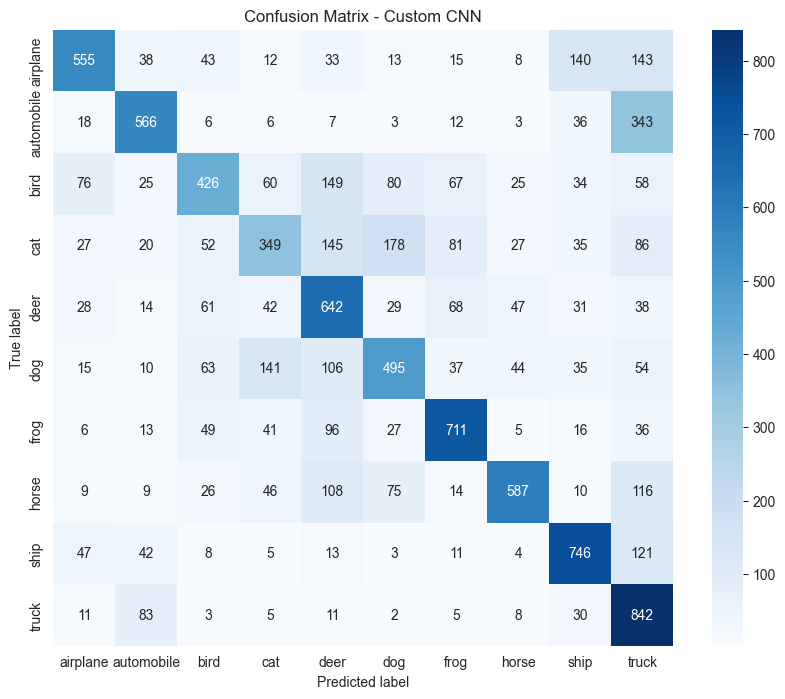

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


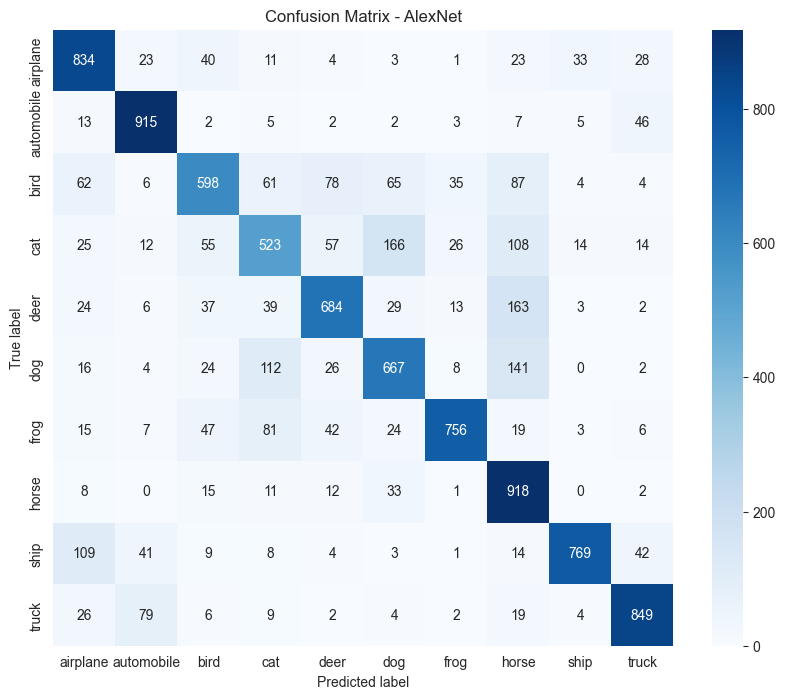

In [81]:

def plot_confusion_matrix(model, test_images, test_labels, class_names, title):
    preds = model.predict(test_images)
    preds_classes = np.argmax(preds, axis=1)
    cm = confusion_matrix(test_labels, preds_classes)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return cm

cifar10_classes = ['airplane','automobile','bird','cat','deer',
                   'dog','frog','horse','ship','truck']

custom_cnn_cm = plot_confusion_matrix(custom_cnn, cifar_test_images, cifar_test_labels, cifar10_classes, "Custom CNN")
alexnet_model_cm = plot_confusion_matrix(alexnet_model, cifar_test_images, cifar_test_labels, cifar10_classes, "AlexNet")


# 6. Class Performance and Improvement

From confusion matrices, we identify classes with poor accuracy.

To improve, we apply data augmentation targeted on training samples of these weak classes:

- Rotation (±15 degrees)
- Horizontal flip
- Zooming (0.9-1.1 scale)

Then, retrain the custom CNN on augmented data and observe improvements.


In [82]:
def plot_per_class_accuracy(accuracies, class_names, highlight_worst_n=4):

    worst_indices = np.argsort(accuracies)[:highlight_worst_n]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_names, accuracies, color='skyblue')

    for i in worst_indices:
        bars[i].set_color('red')

    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=9)

    plt.ylim(0, 1.05)
    plt.title("Per-Class Accuracy on CIFAR-10")
    plt.ylabel("Accuracy")
    plt.xlabel("Class")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


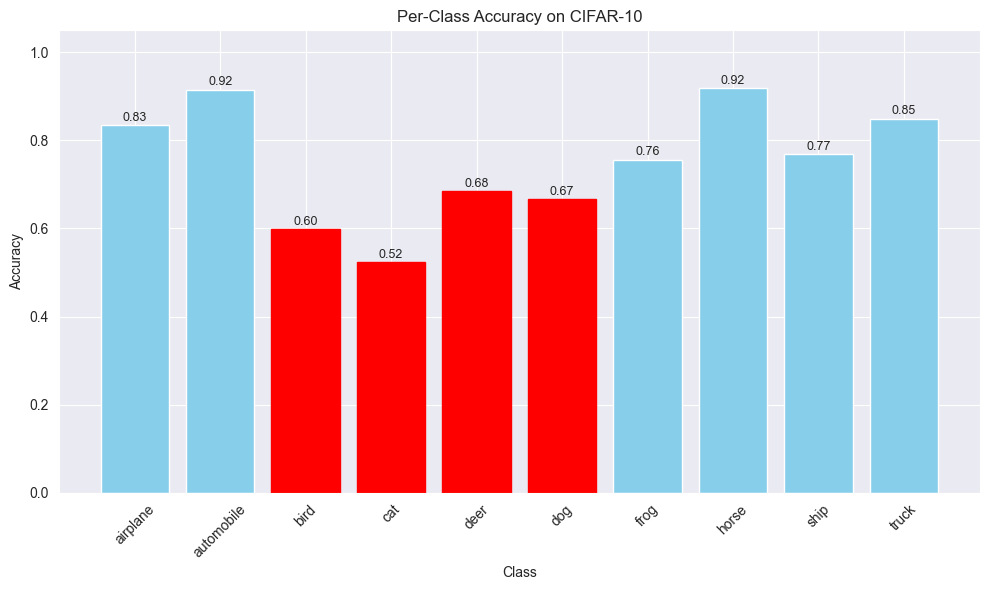

In [83]:
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

y_true = cifar_test_labels.flatten()
y_pred = np.argmax(alexnet_model.predict(cifar_test_images), axis=1)

cm = confusion_matrix(y_true, y_pred)

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_accuracies = np.diag(cm_norm)

plot_per_class_accuracy(class_accuracies, cifar10_classes)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


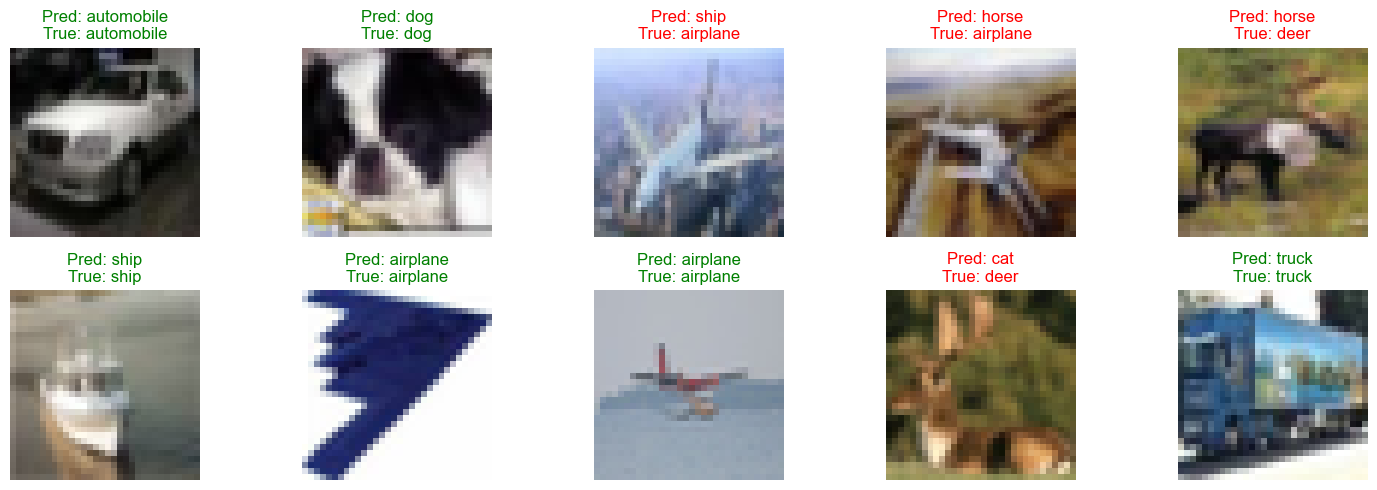

In [84]:
import random

def show_predictions(model, images, labels, class_names, num_images=10):
    plt.figure(figsize=(15, 5))
    indices = random.sample(range(len(images)), num_images)

    predictions = model.predict(images)
    pred_labels = np.argmax(predictions, axis=1)

    for i, idx in enumerate(indices):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(images[idx])
        true_label = class_names[labels[idx][0]] if labels.ndim > 1 else class_names[labels[idx]]
        predicted_label = class_names[pred_labels[idx]]
        color = 'green' if true_label == predicted_label else 'red'
        plt.title(f"Pred: {predicted_label}\nTrue: {true_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_predictions(alexnet_model, cifar_test_images, cifar_test_labels, cifar10_classes, num_images=10)


In [99]:
weak_classes = ['bird', 'cat', 'deer', 'dog']
weak_class_indices = [cifar10_classes.index(cls) for cls in weak_classes]

# Filter training data for weak classes
def filter_classes(images, labels, classes_idx):
    idx = np.isin(labels.flatten(), classes_idx)
    return images[idx], labels[idx]

weak_train_images, weak_train_labels = filter_classes(sampled_train_images, sampled_train_labels, weak_class_indices)

print(f"Number of samples for weak classes before augmentation: {weak_train_images.shape[0]}")


Number of samples for weak classes before augmentation: 20000


In [114]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)

aug_iter = aug_datagen.flow(weak_train_images, weak_train_labels, batch_size=64)

augmented_images, augmented_labels = [], []
for _ in range(len(weak_train_images) // 64):
    imgs, lbls = next(aug_iter)
    augmented_images.append(imgs)
    augmented_labels.append(lbls)

augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)

augmented_labels = np.array(augmented_labels).flatten()

print(f"Augmented samples created: {augmented_images.shape[0]}")


Augmented samples created: 19968


In [115]:
new_train_images = np.concatenate([sampled_train_images, augmented_images])
new_train_labels = np.concatenate([sampled_train_labels, augmented_labels])

new_train_labels = np.array(new_train_labels).flatten()

print(f"New training dataset size: {new_train_images.shape[0]}")


New training dataset size: 69968


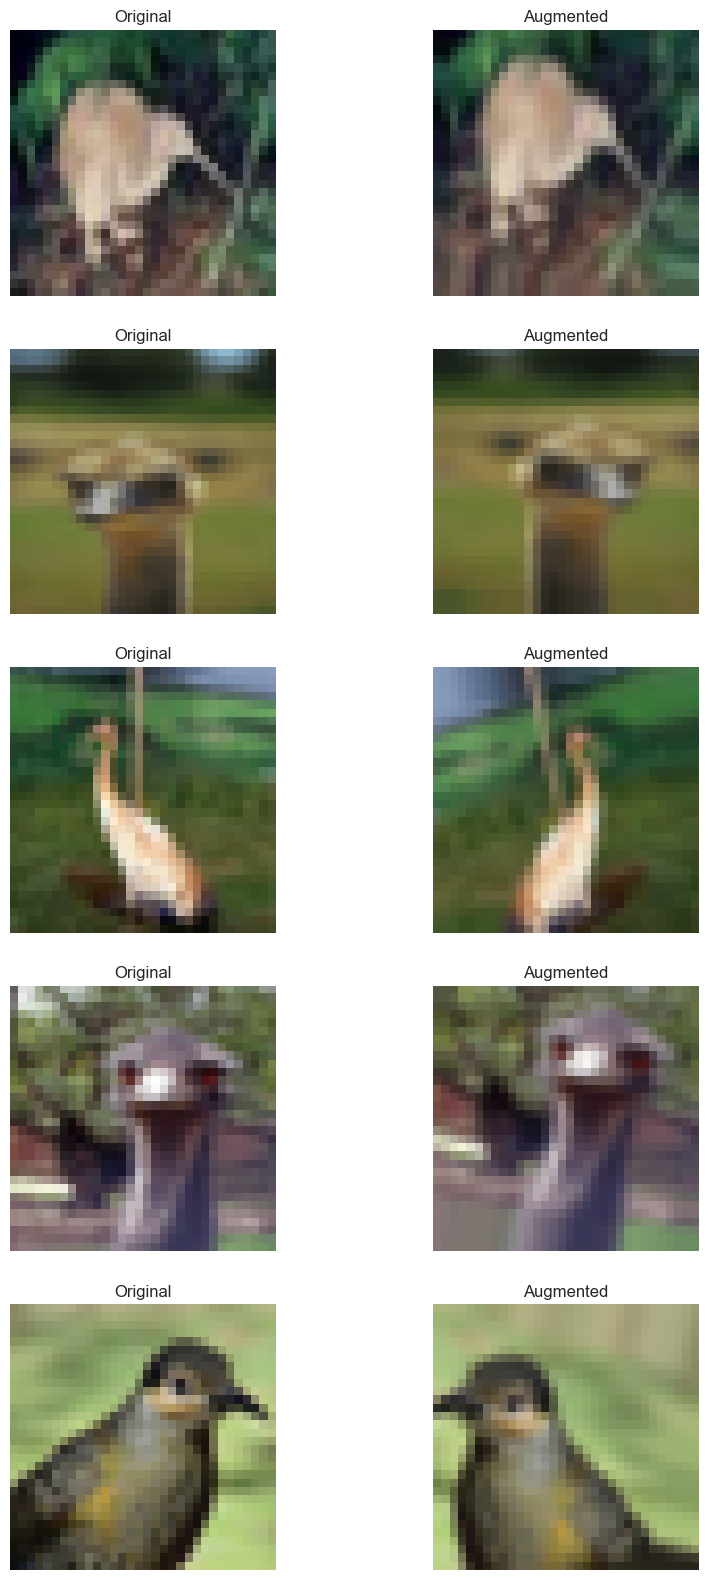

In [116]:
def plot_augmented_samples(generator, original_images, n_samples=5):
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 20))
    for i in range(n_samples):
        axes[i,0].imshow(original_images[i])
        axes[i,0].set_title("Original")
        axes[i,0].axis('off')

        augmented = generator.random_transform(original_images[i])
        axes[i,1].imshow(augmented)
        axes[i,1].set_title("Augmented")
        axes[i,1].axis('off')
    plt.show()

sample_images = weak_train_images[:5]
plot_augmented_samples(aug_datagen, sample_images)

In [117]:
custom_cnn_aug = create_custom_cnn()

X_train, X_val, y_train, y_val = train_test_split(
    new_train_images, new_train_labels, test_size=0.2, random_state=42, stratify=new_train_labels)

custom_cnn_aug.compile(optimizer=optimizers.Adam(learning_rate=1e-4, clipvalue=1.0),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

history_custom_aug = custom_cnn_aug.fit(X_train, y_train,
                                        epochs=15,
                                        batch_size=64,
                                        validation_data=(X_val, y_val),)


/Users/tudoriliescu/MH/Iliescu_Tudor_L6/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.2646 - loss: 2.8043 - val_accuracy: 0.4408 - val_loss: 1.6208
Epoch 2/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.4057 - loss: 1.8519 - val_accuracy: 0.4949 - val_loss: 1.4660
Epoch 3/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.4583 - loss: 1.6242 - val_accuracy: 0.5105 - val_loss: 1.3873
Epoch 4/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.4867 - loss: 1.5090 - val_accuracy: 0.5199 - val_loss: 1.3787
Epoch 5/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.5156 - loss: 1.4243 - val_accuracy: 0.5296 - val_loss: 1.3240
Epoch 6/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.5283 - loss: 1.3849 - val_accuracy: 0.5519 - val_loss: 1.2614
Epoch 7/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.5330 - loss: 1.3610 - val_accuracy: 0.5184 - val_loss: 1.3913
Epoch 8/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.5445 - loss: 1.3304 - 

In [119]:
alexnet_aug = create_alexnet()
alexnet_aug.compile(optimizer=optimizers.Adam(learning_rate=1e-4, clipvalue=1.0),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(
    new_train_images, new_train_labels, test_size=0.2, random_state=42, stratify=new_train_labels)

history_custom_aug = alexnet_aug.fit(X_train, y_train,
                                        epochs=15,
                                        batch_size=64,
                                        validation_data=(X_val, y_val))


/Users/tudoriliescu/MH/Iliescu_Tudor_L6/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 53s 59ms/step - accuracy: 0.2562 - loss: 3.9345 - val_accuracy: 0.4582 - val_loss: 1.8778
Epoch 2/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 56s 64ms/step - accuracy: 0.3476 - loss: 3.9192 - val_accuracy: 0.4901 - val_loss: 2.0058
Epoch 3/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 56s 65ms/step - accuracy: 0.4153 - loss: 3.1896 - val_accuracy: 0.5500 - val_loss: 1.7939
Epoch 4/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 56s 64ms/step - accuracy: 0.4802 - loss: 2.5864 - val_accuracy: 0.5897 - val_loss: 1.5864
Epoch 5/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 54s 62ms/step - accuracy: 0.5355 - loss: 2.0318 - val_accuracy: 0.5944 - val_loss: 1.5230
Epoch 6/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 54s 61ms/step - accuracy: 0.5879 - loss: 1.6375 - val_accuracy: 0.6306 - val_loss: 1.3173
Epoch 7/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 53s 61ms/step - accuracy: 0.6217 - loss: 1.4010 - val_accuracy: 0.6858 - val_loss: 1.0223
Epoch 8/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 53s 61ms/step - accuracy: 0.6655 - loss: 1.1572 - 

313/313 - 1s - 4ms/step - accuracy: 0.5549 - loss: 1.4043
Custom CNN with Augmentation Test Accuracy: 0.5549
313/313 - 3s - 9ms/step - accuracy: 0.7226 - loss: 1.3462
AlexNet with Augmentation Test Accuracy: 0.7226
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


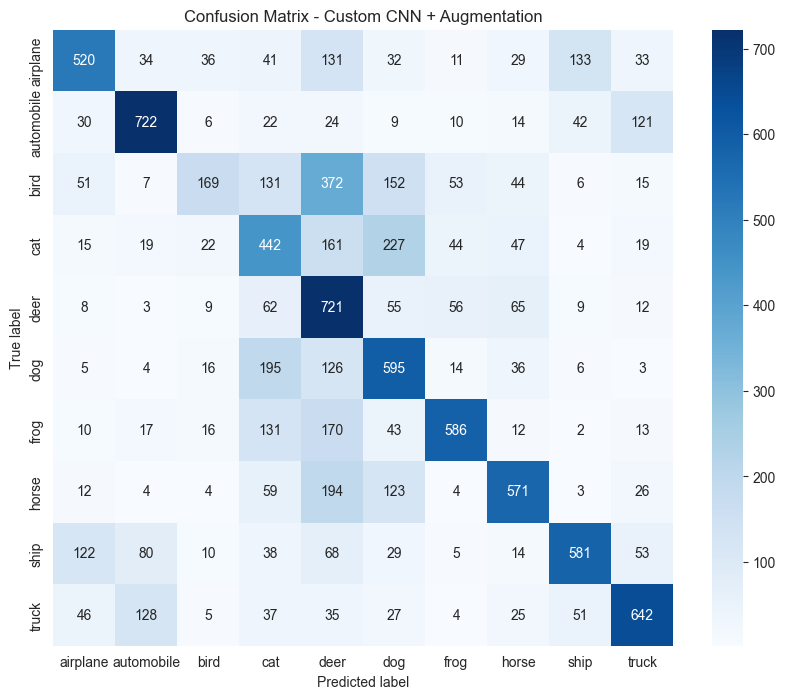

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


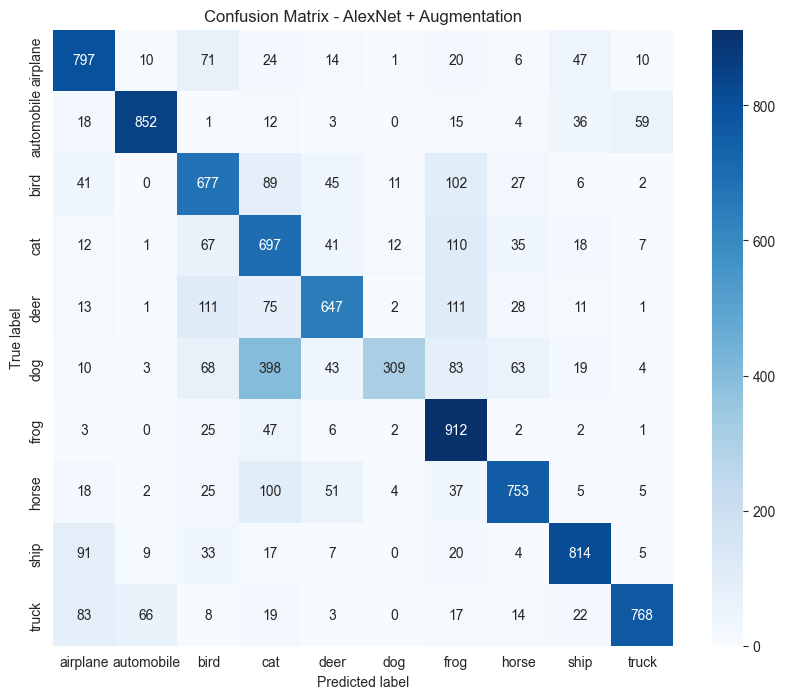

array([[797,  10,  71,  24,  14,   1,  20,   6,  47,  10],
       [ 18, 852,   1,  12,   3,   0,  15,   4,  36,  59],
       [ 41,   0, 677,  89,  45,  11, 102,  27,   6,   2],
       [ 12,   1,  67, 697,  41,  12, 110,  35,  18,   7],
       [ 13,   1, 111,  75, 647,   2, 111,  28,  11,   1],
       [ 10,   3,  68, 398,  43, 309,  83,  63,  19,   4],
       [  3,   0,  25,  47,   6,   2, 912,   2,   2,   1],
       [ 18,   2,  25, 100,  51,   4,  37, 753,   5,   5],
       [ 91,   9,  33,  17,   7,   0,  20,   4, 814,   5],
       [ 83,  66,   8,  19,   3,   0,  17,  14,  22, 768]])

In [120]:
test_loss_aug, test_acc_aug = custom_cnn_aug.evaluate(cifar_test_images, cifar_test_labels, verbose=2)
print(f"Custom CNN with Augmentation Test Accuracy: {test_acc_aug:.4f}")

test_loss_alex_aug, test_acc_alex_aug = alexnet_aug.evaluate(cifar_test_images, cifar_test_labels, verbose=2)
print(f"AlexNet with Augmentation Test Accuracy: {test_acc_alex_aug:.4f}")

plot_confusion_matrix(custom_cnn_aug, cifar_test_images, cifar_test_labels, cifar10_classes, "Custom CNN + Augmentation")
plot_confusion_matrix(alexnet_aug, cifar_test_images, cifar_test_labels, cifar10_classes, "AlexNet + Augmentation")


Contrary to our initial hypothesis, applying targeted data augmentation decreased the overall test accuracy for both models.

- Custom CNN Accuracy: Dropped from 59.2% to 55.5%

- AlexNet Accuracy: Dropped from 75.1% to 72.3%

A likely explanation for this is the introduction of class imbalance. By augmenting only the weak classes and adding them to the training data, we created a dataset where these classes were significantly over-represented. This can bias the model during training, causing it to favor predicting the over-sampled classes. While it may have learned their features better, its performance on the other, previously well-performing classes suffered. Since the test set remains balanced, this new bias leads to a lower overall accuracy score.

# 7. Conclusion

- The AlexNet-inspired model significantly outperforms the custom CNN in terms of accuracy but at the cost of longer training time and a much larger number of parameters.

- The custom CNN is more computationally efficient but provides lower accuracy, highlighting the trade-off between model complexity and performance.

- Targeted data augmentation on weak classes was attempted as a strategy to improve performance. However, this approach led to a decrease in overall test accuracy. The likely cause was the introduction of class imbalance into the training data, which biased the models' predictions.

- The training curves and confusion matrices effectively illustrate the differences between the two architectures and show that while data augmentation is a powerful technique, its application must be carefully considered to avoid unintended negative consequences.


# 8. Future Improvements

- Augment All Data Equally: Instead of only augmenting the weak classes, apply simple changes like random flips and rotations to all of the training images. This makes the model more robust without creating the class imbalance that previously lowered our accuracy.

- Tune the Training Process: We can experiment with key settings to find a better result:

    - Learning Rate: Try adjusting how much the model learns in each step. Sometimes, starting with a larger learning rate and making it smaller over time helps.

    - Epochs: Train the model for more epochs to see if the accuracy continues to improve with more time.

    - Dropout Rate: Experiment with different dropout values (e.g., 0.4 or 0.5) to find a better balance for preventing overfitting.
- Advanced Optimization and Regularization:

    - Learning Rate Scheduling: Instead of a fixed learning rate, a dynamic schedule can guide the model to a better minimum.

        - ReduceLROnPlateau: Monitor the validation loss and automatically reduce the learning rate by a specified factor when the metric has stopped improving.

        - Cosine Annealing: Vary the learning rate cyclically according to a cosine function, which can help the model escape local minima and converge more effectively.